# ADMET

# Lead compound defination

``A lead compound is a chemical compound that has pharmacological or biological activity likely to be therapeutically useful, but may nevertheless have suboptimal structure that requires modification to fit better to the target; lead drugs offer the prospect of being followed by back-up compounds.``

source: [wiki](https://en.wikipedia.org/wiki/Lead_compound#cite_note-Early_Drug_Discovery-1)

# ADMET criteria

__Lipinski's Rule of 5 /Pfizer's rule of five__

- Molecular weight (MWT) <= 500 Da
- Number of hydrogen bond acceptors (HBAs) <= 10
- Number of hydrogen bond donors (HBD) <= 5 
- Calculated LogP (octanol-water coefficient) <= 5


# Filters in medicinal chemistry

1. Lipinski Rule of 5

2. Ghose Filter

3. Veber Filter

4. Rule of 3 Filter

5. REOS Filter

6. Drug-like Filter (QED)

__Lipinski__:

    Moleculer Weight <= 500
    LogP <= 5
    H-Bond Donor Count <= 5
    H-Bond Acceptor Count <= 10
    
__Ghose__:

    Molecular weight between 160 and 480
    LogP between -0.4 and +5.6
    Atom count between 20 and 70
    Molar refractivity between 40 and 130

__Veber__:

    Rotatable bonds <= 10
    Topological polar surface area <= 140

__REOS__:

    Molecular weight between 200 and 500
    LogP between -5.0 and +5.0
    H-bond donor count between 0 and 5
    H-bond acceptor count between 0 and 10
    Formal charge between -2 and +2
    Rotatable bond count between 0 and 8
    Heavy atom count between 15 and 50

__Rule of 3__:

    Molecular weight <= 300
    LogP <= 3
    H-bond donor <= 3
    H-bond acceptor count <= 3
    Rotatable bond count <= 3

__Drug-Like (QED)__:

    mass < 400
    ring count > 0
    rotatable bond count < 5
    h-bond donor count <= 5
    h-bond acceptor count <= 10
    logP < 5
    
*Ref:* https://sharifsuliman1.medium.com/understanding-drug-likeness-filters-with-rdkit-and-exploring-the-withdrawn-database-ebd6b8b2921e

# In this work we will test Lipinski's Ro5

In [1]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

from rdkit.Chem import rdFMCS

from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

from tqdm.auto import tqdm

In [2]:
molecules = pd.read_csv("data/BTK_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(2750, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515


In [3]:
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902,
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,

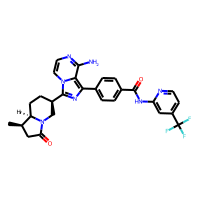
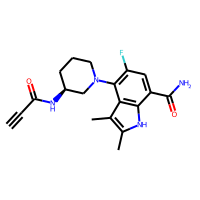
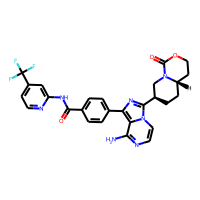
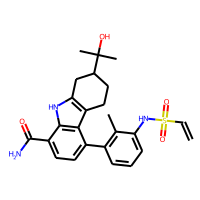
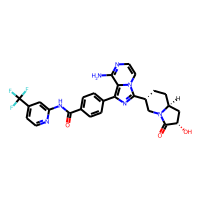

In [4]:
molecules.head()

# Alternate way of adding ROMol object


# function

# Ref: [Teachopencadd](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T002_compound_adme/talktorial.ipynb) 

In [5]:

def check_ro5(smiles):
    
    # Making sure it's canonical SMILES
    cano_smi = Chem.CanonSmiles(smiles)
    
    ## Molecule from SMILES
    molecule = Chem.MolFromSmiles(cano_smi)
    
    ## RO5 properties
    mw = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)

    conditions = [mw <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    
    ro5_fulfilled = sum(conditions) >= 3
    
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [mw, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )


In [6]:

ro5_properties = molecules["smiles"].apply(check_ro5)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,549.210008,7,2,4.75900,True
1,356.164854,3,3,1.74094,True
2,551.189272,8,2,4.73290,True
3,467.187877,4,4,4.00322,True
4,551.189272,8,3,3.48380,True


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,,549.210008,7,2,4.75900,True
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902,,356.164854,3,3,1.74094,True
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,,551.189272,8,2,4.73290,True
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,,467.187877,4,4,4.00322,True
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,,551.189272,8,3,3.48380,True

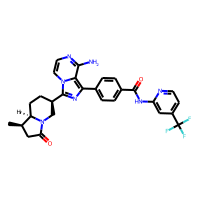
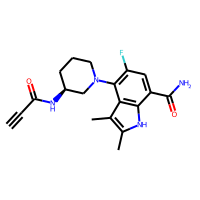
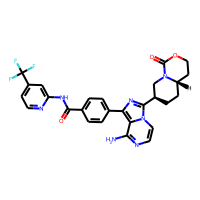
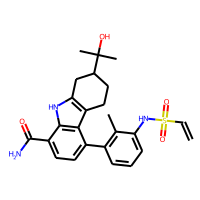
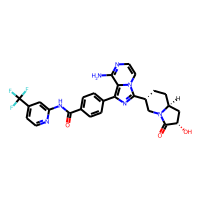

In [7]:
## catenating two dataframes
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

In [8]:
# Counting true and false entries

molecules.ro5_fulfilled.value_counts()

True     1940
False     810
Name: ro5_fulfilled, dtype: int64

In [9]:
df_ro5_failed = molecules.loc[molecules['ro5_fulfilled'] == False ]

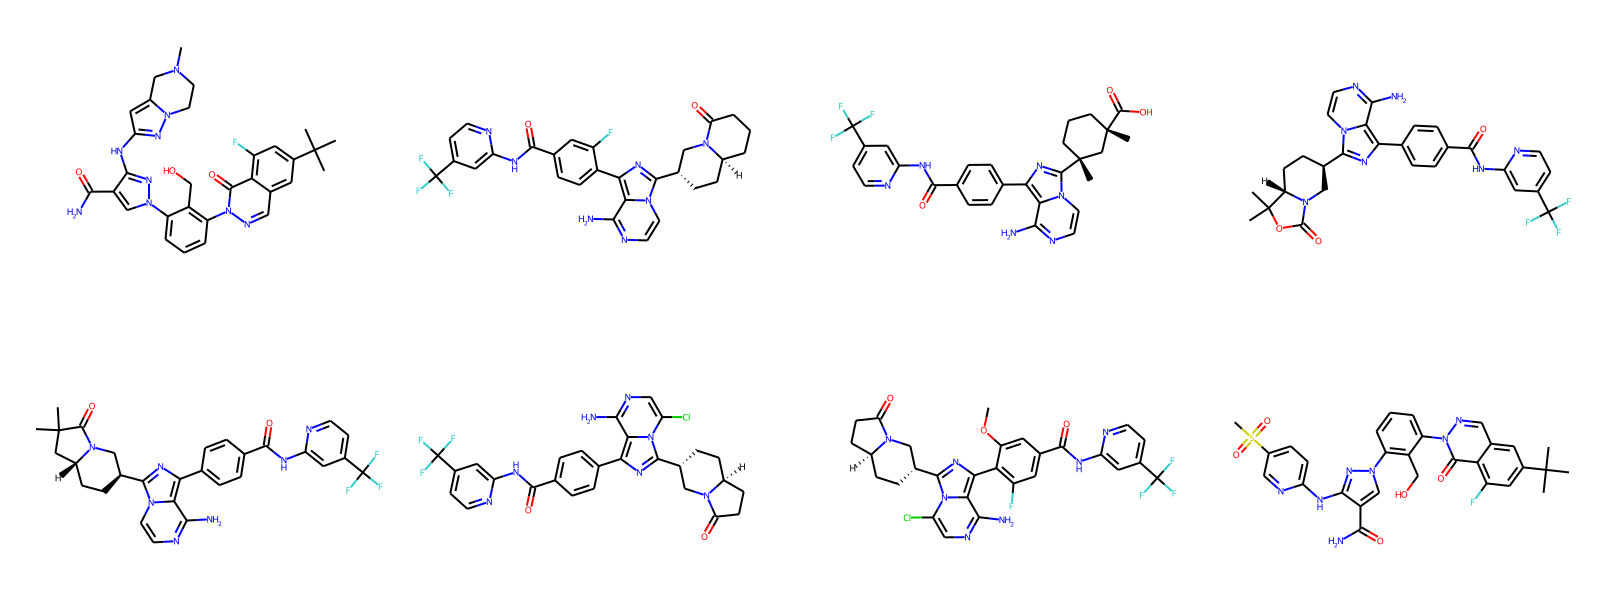

In [10]:
Draw.MolsToGridImage(df_ro5_failed.ROMol.head(8), molsPerRow=4, subImgSize=(400, 300))

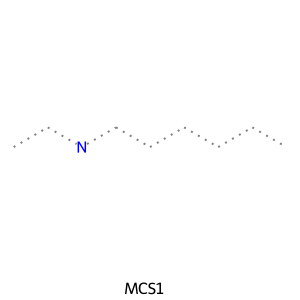

In [11]:
# Checking MCS of these RO5 failed structures

mcs1 = rdFMCS.FindMCS(list(df_ro5_failed.ROMol))
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

In [12]:
import seaborn as sns 

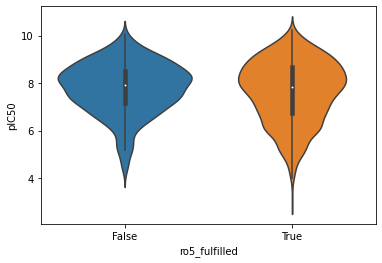

In [13]:
fig = sns.violinplot(x="ro5_fulfilled", y="pIC50", data=molecules)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,,549.210008,7,2,4.75900,True
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902,,356.164854,3,3,1.74094,True
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,,551.189272,8,2,4.73290,True
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,,467.187877,4,4,4.00322,True
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,,551.189272,8,3,3.48380,True

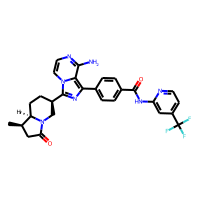
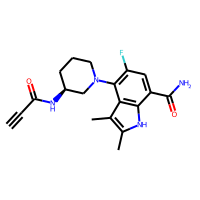
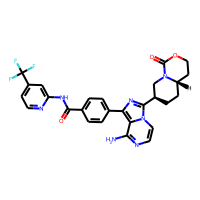
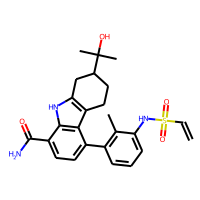
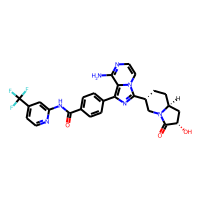

In [14]:
df_ro5_pass = molecules.loc[molecules['ro5_fulfilled'] == True ]
df_ro5_pass.head()

In [15]:
df_ro5_pass.to_csv("data/BTK_compounds_lipinski.csv")

In [16]:
df_ro5_pass.shape

(1940, 11)

# Handling unwanted structures

In [17]:
df_btk = pd.read_csv("data/BTK_compounds_lipinski.csv", index_col=0)
df_btk.shape

(1940, 11)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,,549.210008,7,2,4.75900,True
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902,,356.164854,3,3,1.74094,True
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,,551.189272,8,2,4.73290,True
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,,467.187877,4,4,4.00322,True
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,,551.189272,8,3,3.48380,True

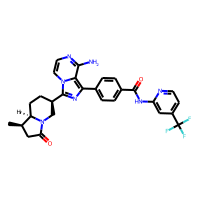
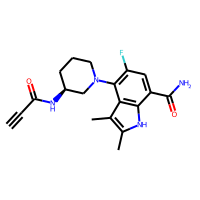
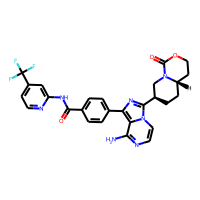
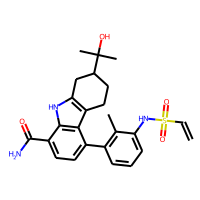
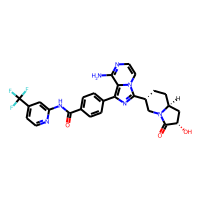

In [18]:
df_btk.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,ro5_fulfilled
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,,True
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902,,True
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,,True
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,,True
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,,True

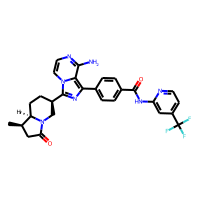
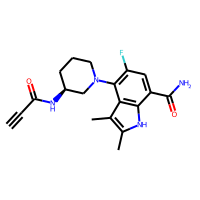
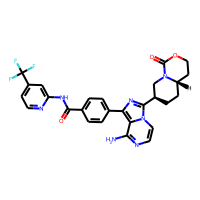
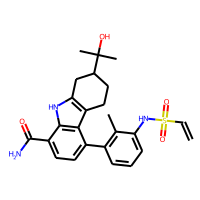
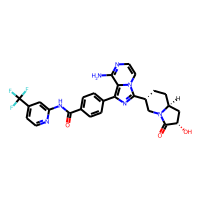

In [19]:
df_btk.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
df_btk.head()

In [20]:
df_btk.iterrows

<bound method DataFrame.iterrows of      molecule_chembl_id        IC50 units  \
0         CHEMBL4113670       0.058    nM   
1         CHEMBL4648442       0.070    nM   
2         CHEMBL4113445       0.075    nM   
3         CHEMBL4240879       0.079    nM   
4         CHEMBL4109744       0.081    nM   
...                 ...         ...   ...   
2745      CHEMBL4793094   83550.000    nM   
2746      CHEMBL3586444  100000.000    nM   
2747      CHEMBL3929151  100000.000    nM   
2748      CHEMBL3586443  240000.000    nM   
2749      CHEMBL3586445  850000.000    nM   

                                                 smiles      pIC50  \
0     C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...  10.236572   
1     C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...  10.154902   
2     Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...  10.124939   
3     C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...  10.102373   
4     Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...  10.091515   
...

## Ref:  [Code reference for PAINS and unwanted substances](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T003_compound_unwanted_substructures/talktorial.ipynb)

In [21]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [22]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(df_btk.iterrows(), total=df_btk.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
df_btk = df_btk.loc[clean]  # keep molecules without PAINS

  0%|          | 0/1940 [00:00<?, ?it/s]

In [23]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(df_btk)}")

Number of compounds with PAINS: 75
Number of compounds without PAINS: 1865


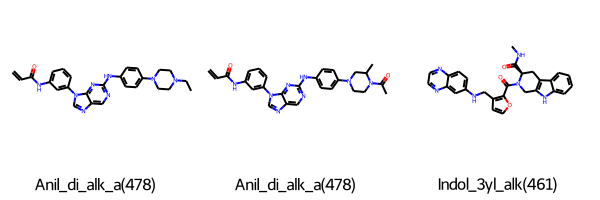

In [24]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

# Filter and highlight unwanted substructures

Reference: Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 535-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).


__unwanted_substructures.csv__ is downloaded from ``https://raw.githubusercontent.com/volkamerlab/teachopencadd/master/teachopencadd/talktorials/T003_compound_unwanted_substructures/data/unwanted_substructures.csv``

In [25]:
substructures = pd.read_csv("data/unwanted_substructures.csv", sep="\s+")


In [26]:
substructures.head(5)

,name,smarts
0,>2EsterGroups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]"
1,2-haloPyridine,"n1c([F,Cl,Br,I])cccc1"
2,acidHalide,"C(=O)[Cl,Br,I,F]"
3,acyclic-C=C-O,C=[C!r]O
4,acylCyanide,N#CC(=O)


In [27]:
substructures["rdkit_molecules"] = substructures.smarts.apply(Chem.MolFromSmarts)

In [28]:
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 104


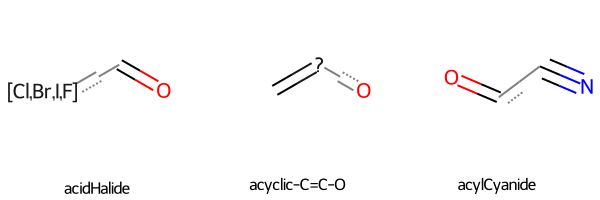

In [29]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecules.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

In [30]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(df_btk.iterrows(), total=df_btk.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecules):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecules,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
df_btk = df_btk.loc[clean]

  0%|          | 0/1865 [00:00<?, ?it/s]

In [31]:
df_btk.shape

(920, 7)

In [32]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(df_btk)}")

Number of found unwanted substructure: 1161
Number of compounds without unwanted substructure: 920


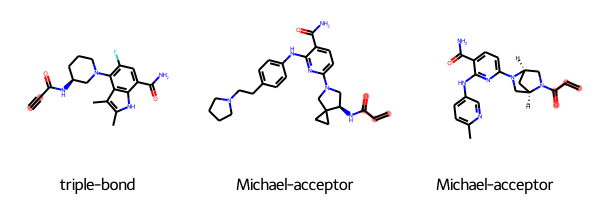

In [33]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

## Substructure Statistics

In [34]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
Michael-acceptor                   709
triple-bond                        165
conjugated-nitrile-group            80
Aliphatic-long-chain                41
aniline                             38
Polycyclic-aromatic-hydrocarbon     19
heavy-metal                         18
imine                               13
Three-membered-heterocycle          11
Oxygen-nitrogen-single-bond         10
dtype: int64

In [35]:
df_btk.shape

(920, 7)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,ro5_fulfilled
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,,True
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,,True
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,,True
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,,True
5,CHEMBL4749037,0.083,nM,Nc1nccn2c([C@@H]3CC[C@H]4COC(=O)N4C3)nc(-c3ccc...,10.080922,,True

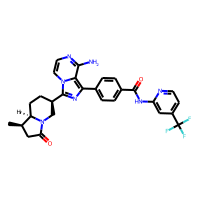
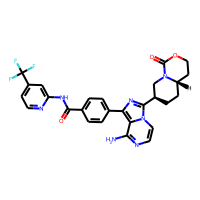
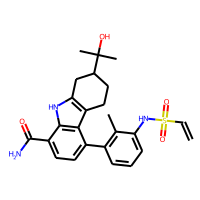
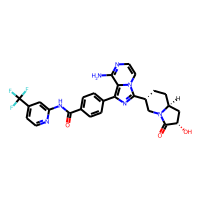
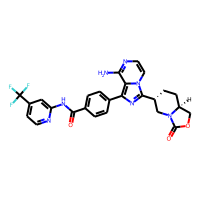

In [36]:
df_btk.head()

In [37]:
df_btk.to_csv("data/BTK_compounds_filtered_PAINS_Brenk.csv")

# Note:
Approximately 5% of FDA-approved drugs contain PAINS.

__Important Functions__
 
``HasSubstructMatch()`` : manual substructure searches,

``FilterCatalog`` : predefined collections of substructures,

``GetFirstMatch()``: First PAINS match per molecule.

__unwanted_substructures.csv__ is downloaded from ``https://raw.githubusercontent.com/volkamerlab/teachopencadd/master/teachopencadd/talktorials/T003_compound_unwanted_substructures/data/unwanted_substructures.csv``


# Reading: 

1. [Seven Year Itch: Pan-Assay Interference Compounds (PAINS) in 2017—Utility and Limitations](https://pubs.acs.org/doi/10.1021/acschembio.7b00903)


2. [Lessons Learnt from Assembling Screening Libraries for Drug Discovery for Neglected Diseases]( https://doi.org/10.1002/cmdc.200700139)